In [72]:
import random
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from scipy.stats import logistic
from scipy.optimize import linprog

sigm = logistic.cdf
colors = ['red', 'green', 'blue', 'orange', 'purple', 'yellow']

# **Experiments for paper**: "*Gradient-free algorithm for saddle point problems under overparametrization*"

In this notebook we observe convegence rates of our algorithm ZOS-SEG with usage of different values of parameters.

We consider the following optimization problem:
\begin{eqnarray}\label{eq:experiments_problems}
    \min_{x \in \mathbb{R}^{d_x}} \max_{y \in \mathbb{R}^{d_y}}f(x,y) = \min_{x \in \mathbb{R}^{d_x}} \max_{y \in \mathbb{R}^{d_y}} \frac{1}{n} \sum_{i=1}^n f_i(x, y),&&\\
    f_i(x, y) := x^T C_i y + \frac{\lambda_i}{2} ||x||^2 - \frac{\lambda_i}{2} ||y||^2,\nonumber
\end{eqnarray} 
where $C_i \in \mathbb{R}^{d_x \times d_y}$ for all $1 \leq i \leq n$, $\lambda_i$ is a regularization paramether and overparameterization condition holds ($d > n$).


The solution of this problem is 0.

In [39]:
# functions for objective function

class Problem:
    def __init__(self, d_x, d_y, Q, n):
        self.dim_x = d_x
        self.dim_y = d_y
        self.dim = d_x + d_y

        self.n = n

        self.Q = Q
        self.C_matrixes, self.lambdas = self.sample_constants()
        
    def sample_constants(self):
        matrixes_C = []
        lambdas = []

        for _ in range(self.n):
            vec = np.random.uniform(-self.Q, self.Q, size=((self.dim_x, self.dim_y)))
            vec /= np.linalg.norm(vec)

            matrixes_C.append(vec)
            lambdas.append(np.random.uniform(0.5, 2, 1)[0])

        return matrixes_C, lambdas
    
    def objective_function_with_idx(self, z, idx):
        x = z[:self.dim_x]
        y = z[self.dim_x:]

        objective = x.T @ self.C_matrixes[idx] @ y + self.lambdas[idx] / 2 * np.linalg.norm(x) ** 2 - self.lambdas[idx] / 2 * np.linalg.norm(y) ** 2
        return objective[0][0]

    def objective_function(self, z):
        x = z[:self.dim_x]
        y = z[self.dim_x:]

        func_sum = 0

        for i in range(self.n):
            objective = x.T @ self.C_matrixes[i] @ y + self.lambdas[i] / 2 * np.linalg.norm(x) ** 2 - self.lambdas[i] / 2 * np.linalg.norm(y) ** 2
            func_sum += objective[0][0]
        return func_sum / self.n

In [54]:
# Algorithm implementation

class ZOS_SEG:
    def __init__(self, Q, problem):
        self.problem = problem
        self.Q = Q
        
        self.z_solve = np.random.uniform(-self.Q, self.Q, size=((self.problem.dim, 1)))
        self.z_start = np.random.uniform(-self.Q, self.Q, size=((self.problem.dim, 1)))
        
    def sample_spherical(self):
        vec = np.random.randn(self.problem.dim, 1)
        vec /= np.linalg.norm(vec)
        return vec
    
    def approx_of_gradient_with_stoch_noise(self, z, tau):
        e = self.sample_spherical()

        cost_function_1 = self.problem.objective_function(z + tau * e) + np.random.randn() / 1000
        cost_function_2 = self.problem.objective_function(z - tau * e) + np.random.randn() / 1000

        grad_approx = self.problem.dim * (cost_function_1 - cost_function_2) * e / (2 * tau)
        return grad_approx

    def approx_of_gradient_with_determ_noise(self, z, tau, idx):
        e = self.sample_spherical()

        cost_function_1 = self.problem.objective_function_with_idx(z + tau * e, idx)
        cost_function_2 = self.problem.objective_function_with_idx(z - tau * e, idx)
        
        cost_function_1 = np.round(cost_function_1, 4)
        cost_function_2 = np.round(cost_function_2, 4)

        grad_approx = self.problem.dim * (cost_function_1 - cost_function_2) * e / (2 * tau)
        return grad_approx
    
    def batch_gradient(self, z, batch_size, tau, idx=None):
        batch_grad = 0

        for i in range(batch_size):
            if idx is None:
                batch_grad += self.approx_of_gradient_with_stoch_noise(z, tau)
            else:
                batch_grad += self.approx_of_gradient_with_determ_noise(z, tau, idx)

        batch_grad /= batch_size
        return batch_grad
    
    def Algorithm_step(self, z, batch_size, stepsize, tau, idx=None):
        grad_k = self.batch_gradient(z, batch_size, tau, idx)
        grad_k[self.problem.dim_x:] *= -1

        z_k = z - stepsize * grad_k

        grad_halfk = self.batch_gradient(z_k, batch_size, tau, idx)
        grad_halfk[self.problem.dim_x:] *= -1

        return z - stepsize * grad_halfk / 8
    
    def Method(self, N, batch_size, stepsize, tau, plot=True, diminish=False):
        z_stoch = np.copy(self.z_start)
        z_determ = np.copy(self.z_start)
        stepsize_stoch, stepsize_det = stepsize, stepsize

        stoch_noise_history, determ_noise_history = [], []

        for i in tqdm(range(N), position=0, leave=True):
            stoch_noise_history.append(np.linalg.norm(z_stoch))
            determ_noise_history.append(np.linalg.norm(z_determ))

            idx = random.randint(0, self.problem.n - 1)

            z_stoch = self.Algorithm_step(z_stoch, batch_size, stepsize_stoch, tau)
            z_determ = self.Algorithm_step(z_determ, batch_size, stepsize_det, tau, idx)
            
            if diminish and (np.linalg.norm(z_stoch) <= 0.0005):
                stepsize_stoch = 1 / i
                
            if diminish and (np.linalg.norm(z_determ) <= 0.00005):
                stepsize_det = 1 / i

        if plot:
            plt.semilogy(np.arange(N), stoch_noise_history, color='purple', label='stochastic noise')
            plt.semilogy(np.arange(N), determ_noise_history, color='crimson', label='determinisric noise')

            plt.xlabel("Number of iterations", fontsize='large')
            plt.ylabel("||z^k - z^*||^2")
            plt.legend()
            plt.show()
        return stoch_noise_history, determ_noise_history

#### Description

We fixate the original problem, dimensions $d_x, d_y$, interval for solution search $Q$, number of iterations, and parameter $n$.

This leaves us with following hyperparameters: stepsize, batch size $B$ and smoothing paramether $\tau$.

Below we will conduct an analysis for optimal values of parameters.

In [55]:
# fixated
n = 32
d_x = 64
d_y = 64
Q = 100
N = 7_000

problem = Problem(d_x, d_y, Q, n)
model = ZOS_SEG(Q, problem)

### Batch_size

100%|██████████| 7000/7000 [00:58<00:00, 119.53it/s]


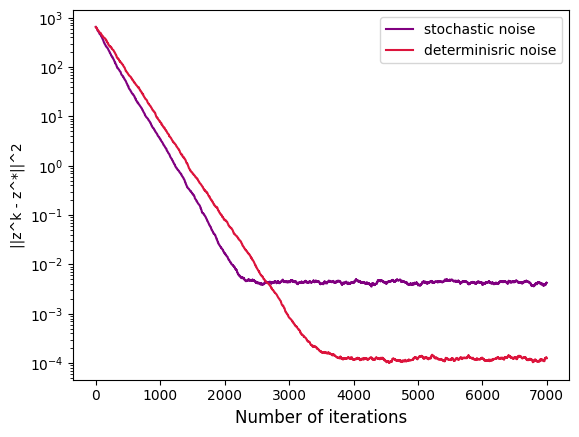

100%|██████████| 7000/7000 [03:51<00:00, 30.19it/s]


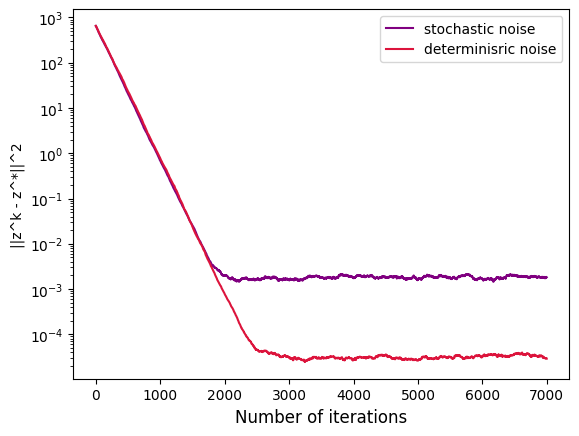

100%|██████████| 7000/7000 [15:05<00:00,  7.73it/s]


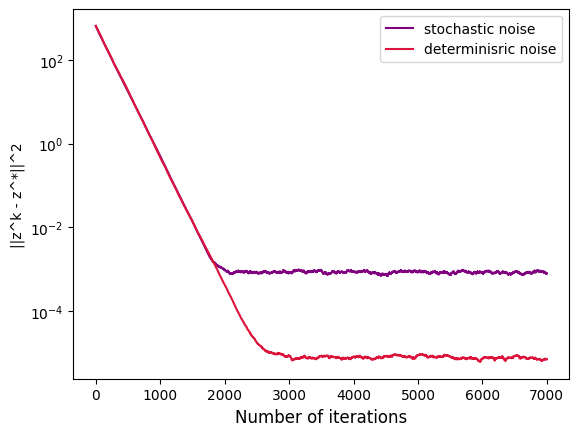

100%|██████████| 7000/7000 [59:22<00:00,  1.96it/s]  


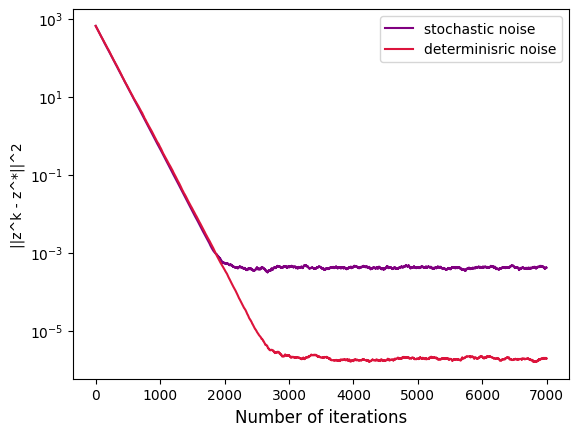

100%|██████████| 4/4 [1:19:20<00:00, 1190.16s/it]


In [49]:
batch_sizes = [2, 8, 32, 128]

stochastic_histories, determ_histories = [], []

for batch in tqdm(batch_sizes, position=0, leave=True):
    stoch, determ = model.Method(N, batch, 0.05, 1)
    stochastic_histories.append(stoch)
    determ_histories.append(determ)

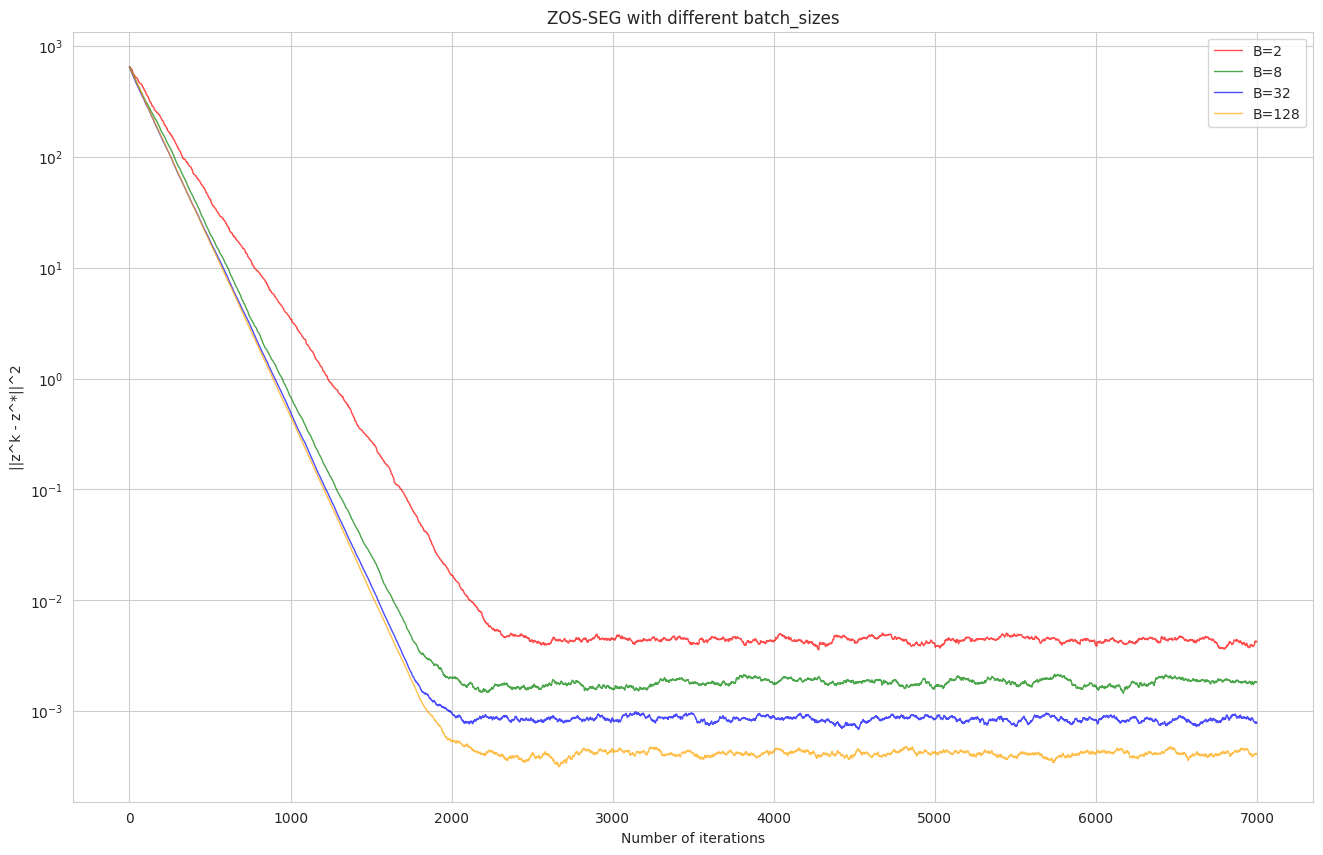

In [52]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(16,10))
    plt.title('ZOS-SEG with different batch_sizes')
    for i in range(len(batch_sizes)):
        plt.plot(np.arange(N), stochastic_histories[i], label=f'B={batch_sizes[i]}', c=colors[i], lw=1, alpha=0.7)
        
    plt.xlabel('Number of iterations')
    plt.ylabel('||z^k - z^*||^2')
    plt.yscale('log')
    plt.legend()

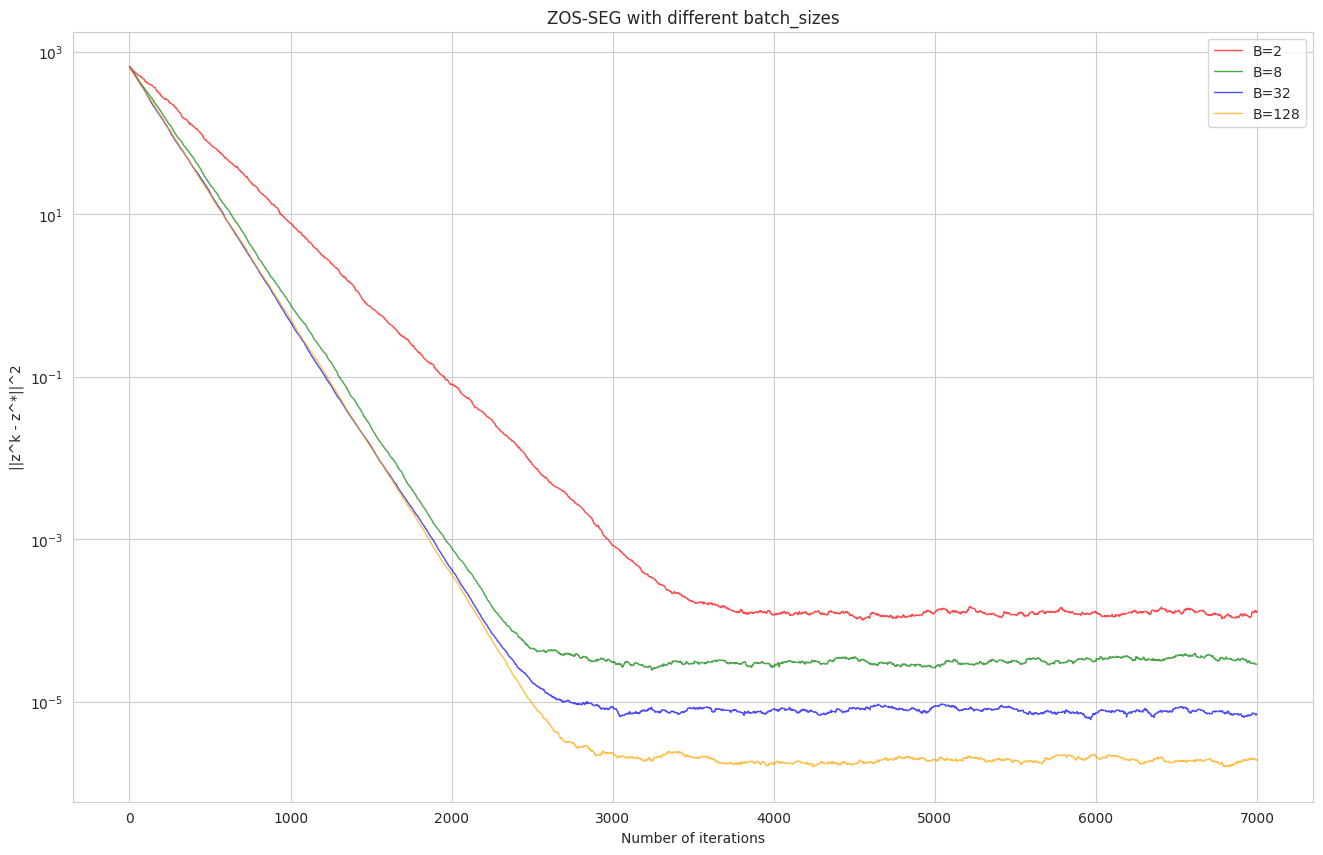

In [53]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(16,10))
    plt.title('ZOS-SEG with different batch_sizes')
    for i in range(len(batch_sizes)):
        plt.plot(np.arange(N), determ_histories[i], label=f'B={batch_sizes[i]}', c=colors[i], lw=1, alpha=0.7)
        
    plt.xlabel('Number of iterations')
    plt.ylabel('||z^k - z^*||^2')
    plt.yscale('log')
    plt.legend()

### Stepsize

100%|██████████| 7000/7000 [59:18<00:00,  1.97it/s] 


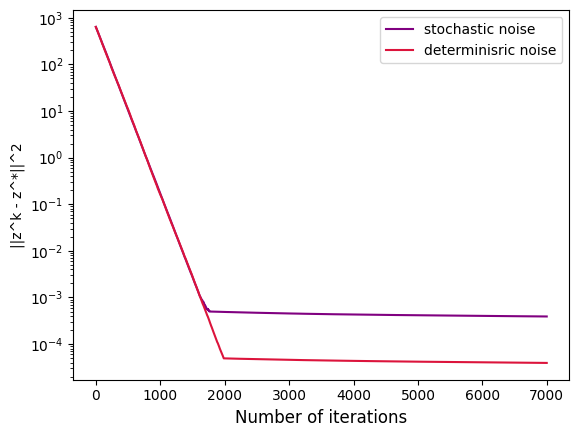

100%|██████████| 7000/7000 [1:00:06<00:00,  1.94it/s]


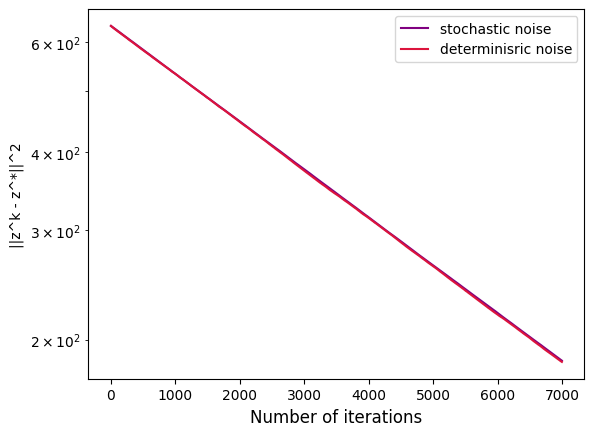

100%|██████████| 7000/7000 [55:54<00:00,  2.09it/s] 


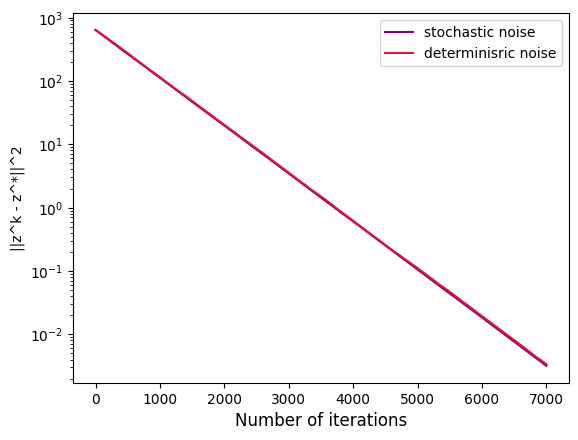

100%|██████████| 7000/7000 [55:28<00:00,  2.10it/s]


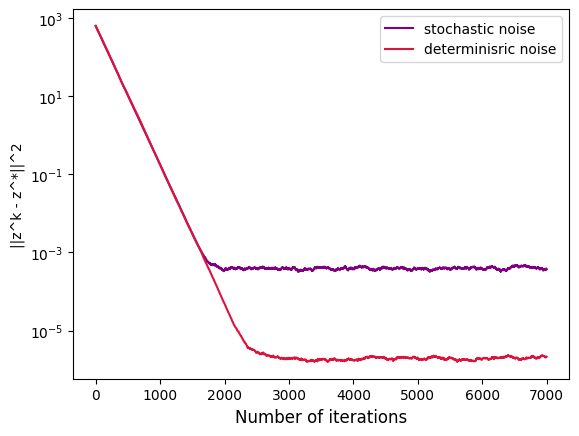

100%|██████████| 4/4 [3:50:50<00:00, 3462.62s/it]


In [58]:
step_sizes = ['diminish,start=0.05', 0.001, 0.01, 0.05, 0.1, 'diminish,start=0.1']

stochastic_histories, determ_histories = [], []

for step in tqdm(step_sizes, position=0, leave=True):
    diminish = ('diminishing' in step)
    step = step if step != 'diminishing' else 0.05
    
    stoch, determ = model.Method(N, 128, step, 1, diminish=diminish)
    stochastic_histories.append(stoch)
    determ_histories.append(determ)

In [68]:
step_sizes = ['diminish,start=0.05', 0.001, 0.01, 0.05, 0.1, 'diminish,start=0.1']

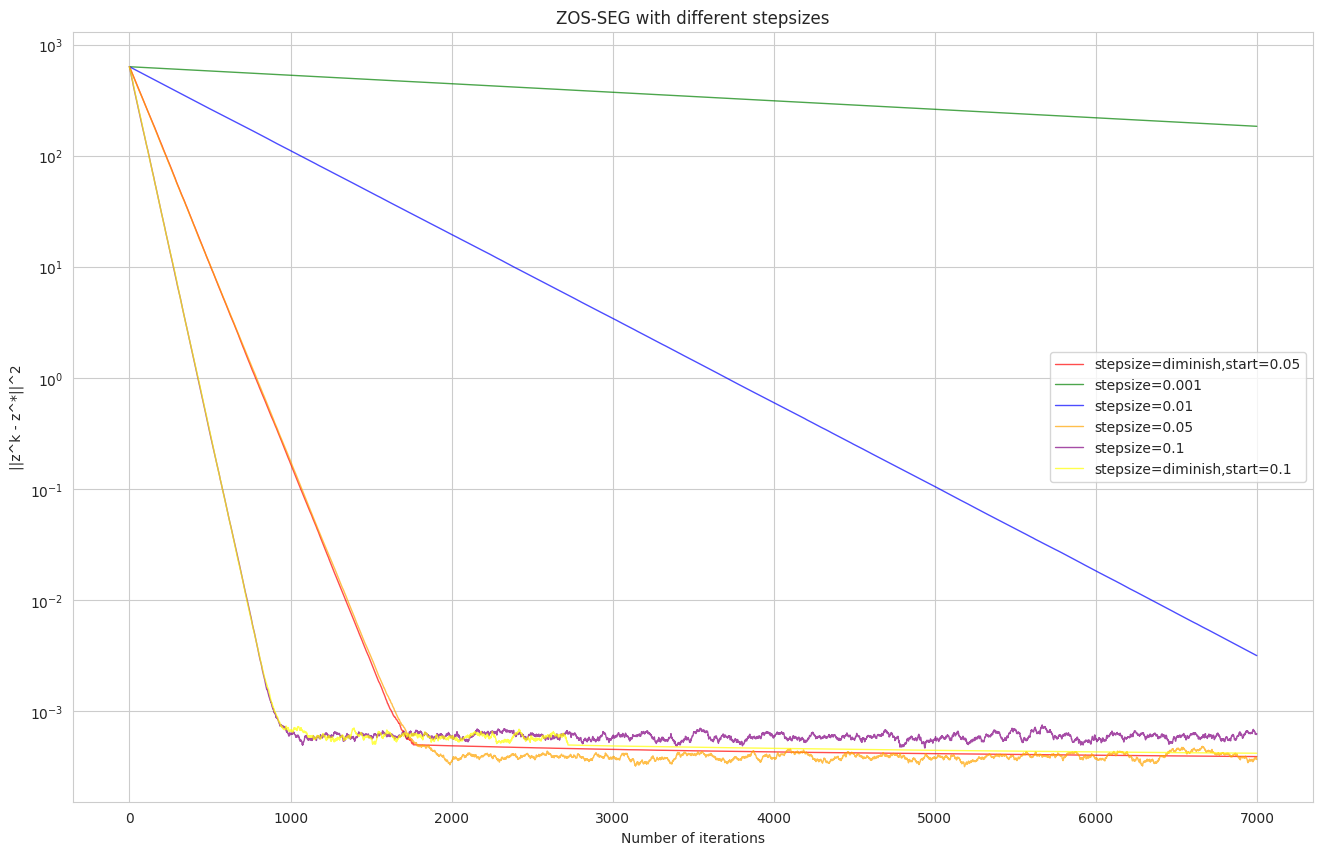

In [73]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(16,10))
    plt.title('ZOS-SEG with different stepsizes')
    for i in range(len(step_sizes)):
        plt.plot(np.arange(N), stochastic_histories[i], label=f'stepsize={step_sizes[i]}', c=colors[i], lw=1, alpha=0.7)
        
    plt.xlabel('Number of iterations')
    plt.ylabel('||z^k - z^*||^2')
    plt.yscale('log')
    plt.legend()

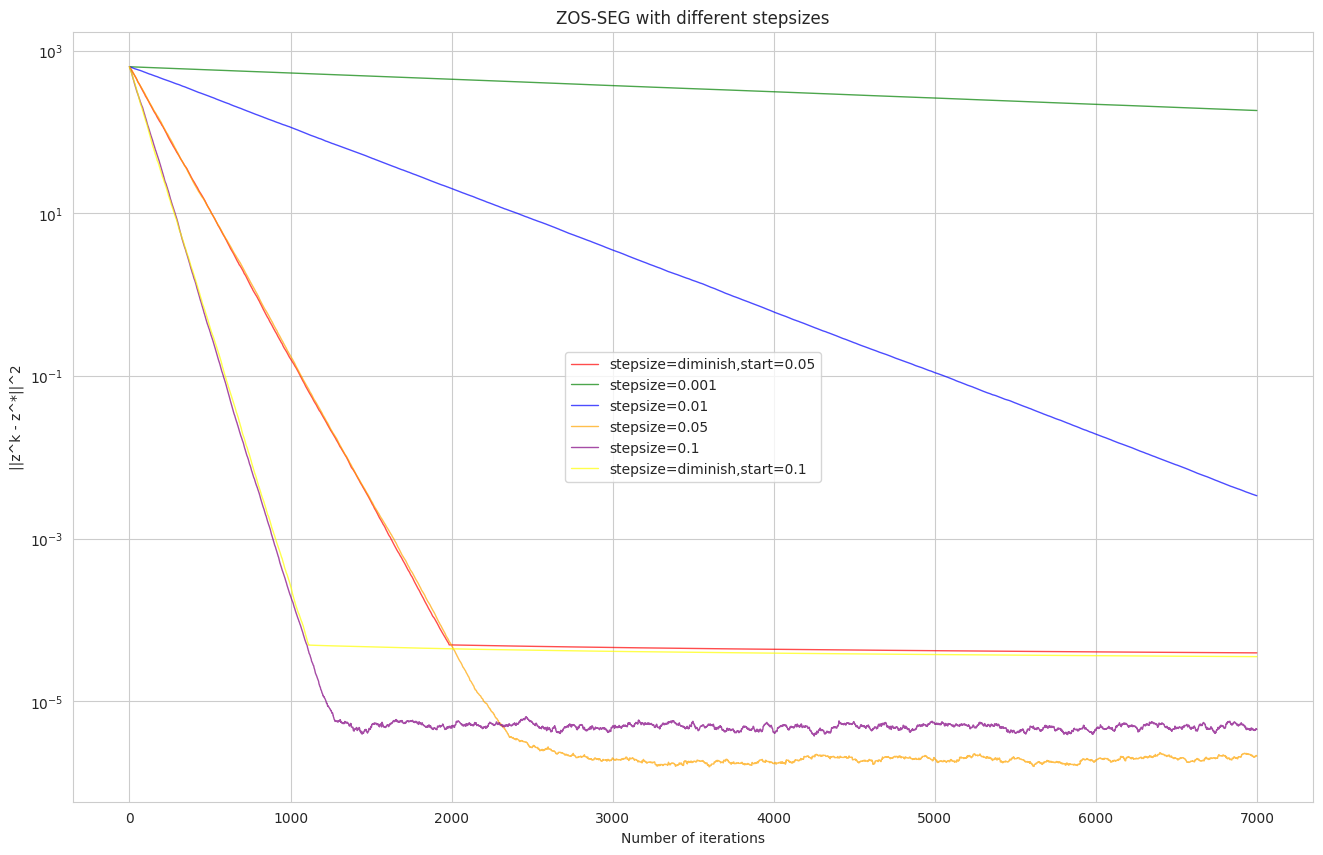

In [74]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(16,10))
    plt.title('ZOS-SEG with different stepsizes')
    for i in range(len(step_sizes)):
        plt.plot(np.arange(N), determ_histories[i], label=f'stepsize={step_sizes[i]}', c=colors[i], lw=1, alpha=0.7)
        
    plt.xlabel('Number of iterations')
    plt.ylabel('||z^k - z^*||^2')
    plt.yscale('log')
    plt.legend()

### Smoothing paramether tau

100%|██████████| 7000/7000 [55:07<00:00,  2.12it/s]


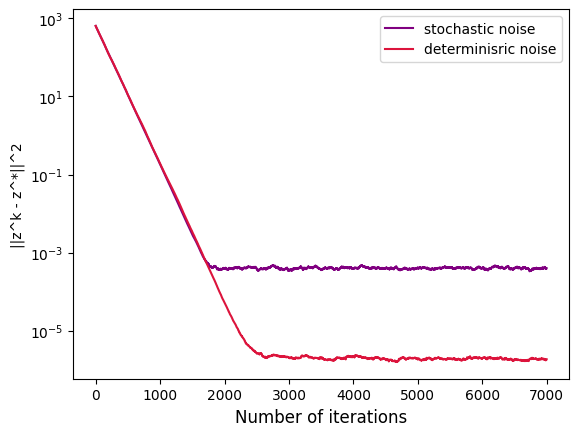

100%|██████████| 7000/7000 [53:57<00:00,  2.16it/s]


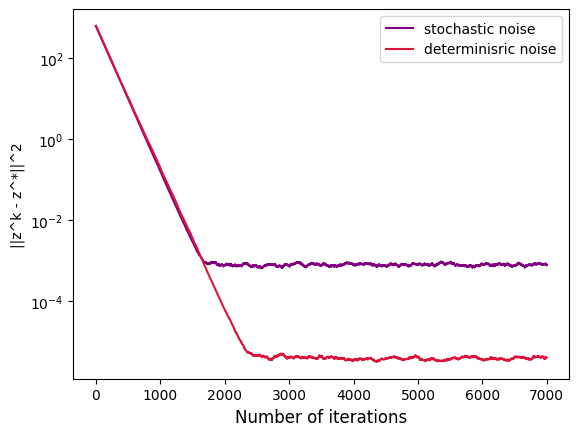

100%|██████████| 7000/7000 [54:35<00:00,  2.14it/s] 


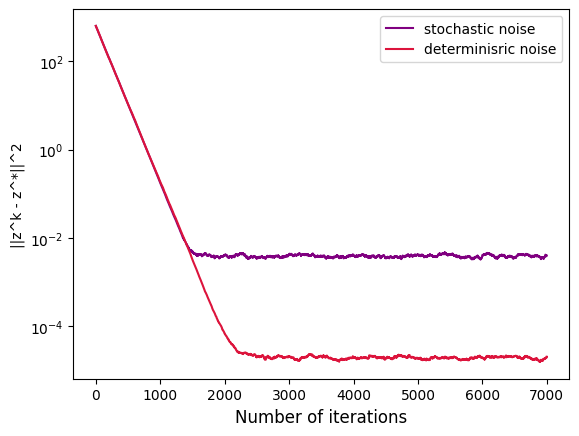

100%|██████████| 7000/7000 [55:14<00:00,  2.11it/s] 


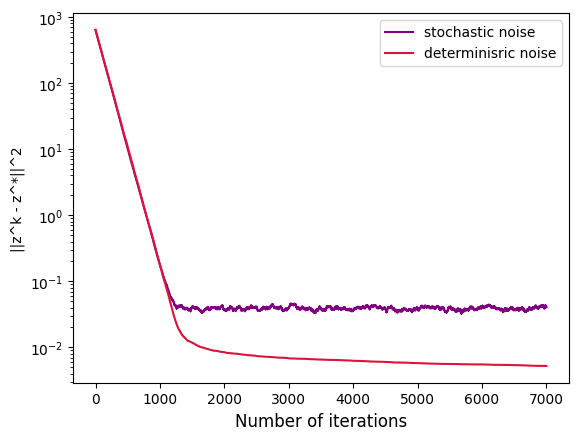

100%|██████████| 7000/7000 [54:53<00:00,  2.13it/s] 


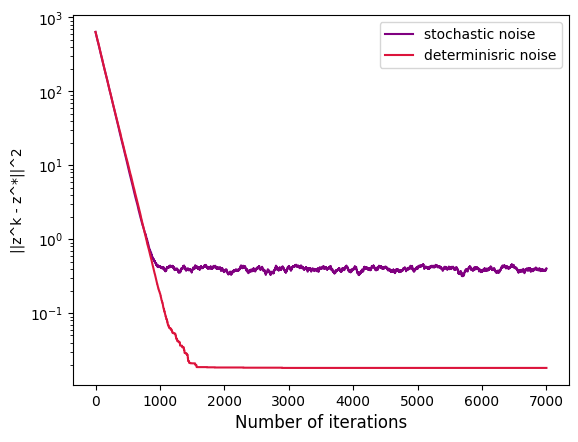

100%|██████████| 5/5 [4:33:51<00:00, 3286.22s/it]


In [75]:
taus = [1, 0.5, 0.1, 0.01, 0.001]

stochastic_histories, determ_histories = [], []

for tau in tqdm(taus, position=0, leave=True):
    stoch, determ = model.Method(N, 128, 0.05, tau)
    stochastic_histories.append(stoch)
    determ_histories.append(determ)

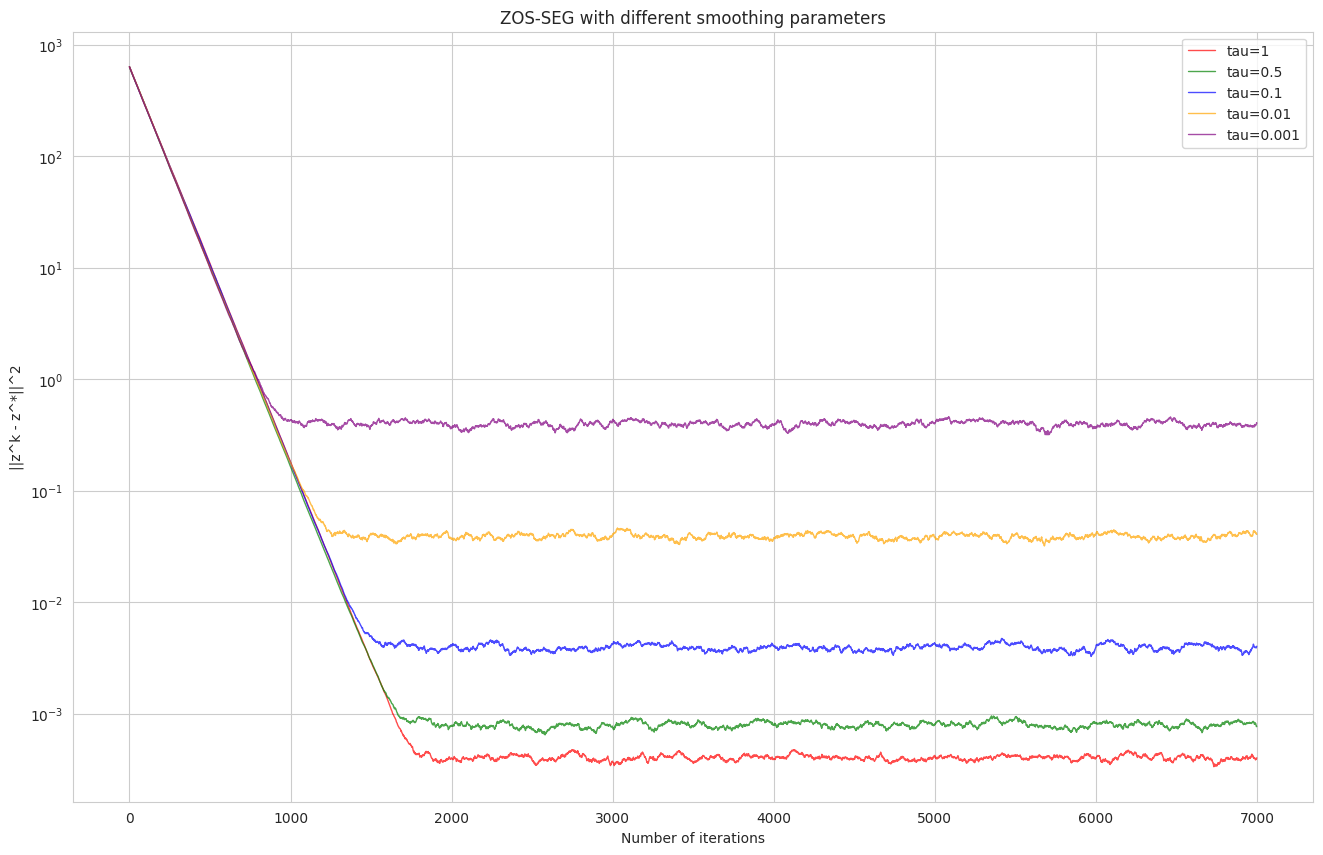

In [76]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(16,10))
    plt.title('ZOS-SEG with different smoothing parameters')
    for i in range(len(taus)):
        plt.plot(np.arange(N), stochastic_histories[i], label=f'tau={taus[i]}', c=colors[i], lw=1, alpha=0.7)
        
    plt.xlabel('Number of iterations')
    plt.ylabel('||z^k - z^*||^2')
    plt.yscale('log')
    plt.legend()

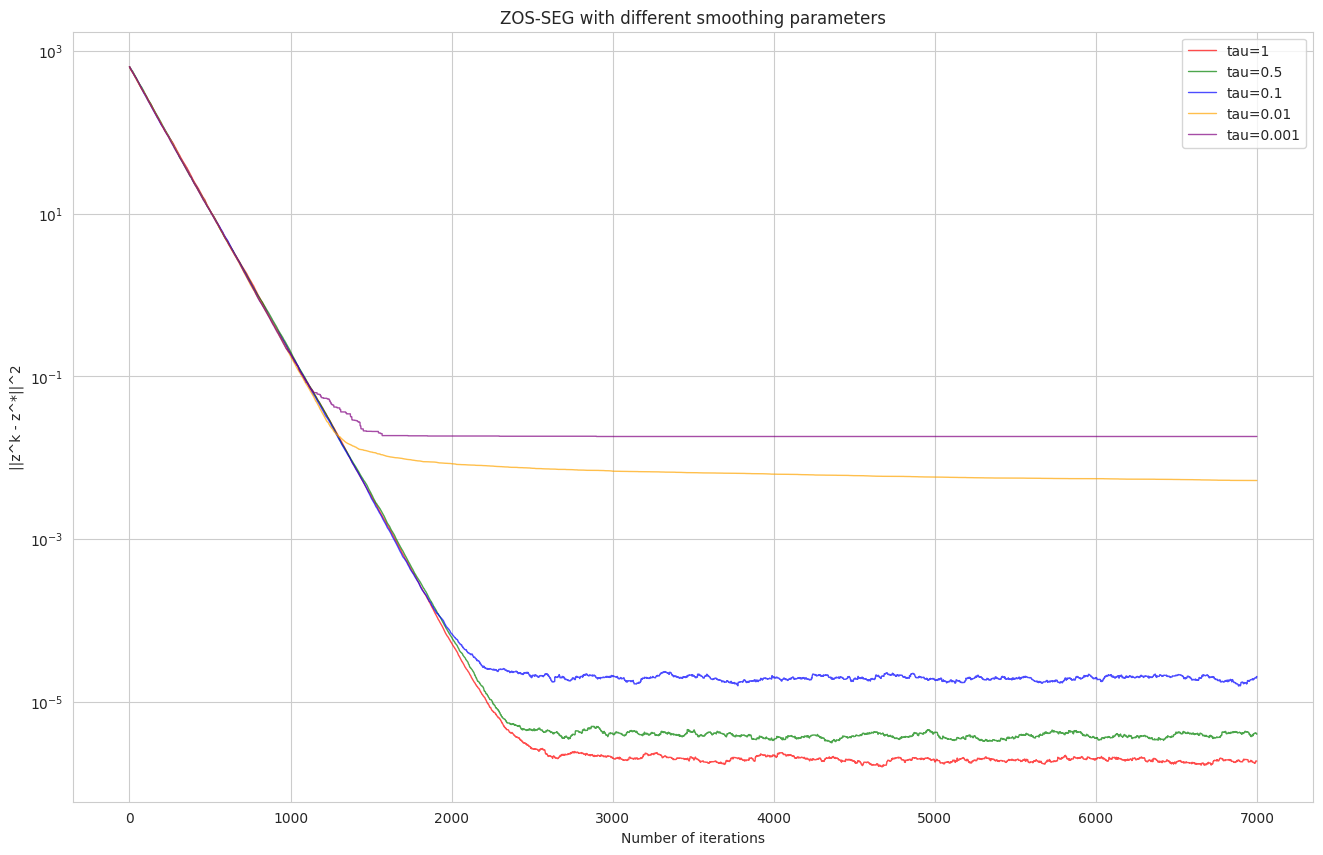

In [77]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(16,10))
    plt.title('ZOS-SEG with different smoothing parameters')
    for i in range(len(taus)):
        plt.plot(np.arange(N), determ_histories[i], label=f'tau={taus[i]}', c=colors[i], lw=1, alpha=0.7)
        
    plt.xlabel('Number of iterations')
    plt.ylabel('||z^k - z^*||^2')
    plt.yscale('log')
    plt.legend()